<a href="https://colab.research.google.com/github/nicolasvazquez95/Aprendiendo_DeepLearning/blob/main/projects/02_SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available in [arXiv](https://arxiv.org/abs/1710.06071).

The model architecture that they use is available here: https://arxiv.org/abs/1612.05251


## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e85751d2-b151-794a-0fd7-e907d7553720)


## Get data
Let's download the dataset they used. It's freely available in GitHub

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [3]:
!tail pubmed-rct/PubMed_20k_RCT/test.txt

METHODS	Both were assessed at baseline , 3 weeks , and 6 weeks .
METHODS	Treatment satisfaction was assessed at week 6 .
METHODS	Adverse effects were also monitored .
RESULTS	There was a statistically significant within-group improvement in VISA-A score for both groups ( standard , P = .03 ; do as tolerated , P < .001 ) and VAS pain for the do-as-tolerated group ( P = .001 ) at week 6 , based on the intention-to-treat analysis .
RESULTS	There was a statistically significant between-group difference in VISA-A scores at week 3 , based on both the intention-to-treat ( P = .004 ) and per-protocol analyses ( P = .007 ) , partly due to a within-group deterioration at week 3 in the standard group .
RESULTS	There were no statistically significant between-group differences for VISA-A and VAS pain scores at week 6 , the completion of the intervention .
RESULTS	There was no significant association between satisfaction and treatment groups at week 6 .
RESULTS	No adverse effects were reported .
CON

We'll start the experiments using the small dataset (20k) with the numbers replaced with `'@'`.

In [4]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
import os 
filenames = [data_dir+filename for filename in os.listdir(data_dir)]

## Preprocess data

In [5]:
def get_text(filename):
  with open(filename,'r') as f:
    return f.readlines()
test = get_text(filenames[0])
train = get_text(filenames[1])
dev = get_text(filenames[2])

__How can we represent this data?__

We can use a dictionary format with the keys: `line_number, target, text`. Our samples will be in a list of dictionaries, one for each line in the text.

In [6]:
def get_list_samples(file):
  """This function receives a written file loaded in memory (i.e. a list of strings). Then it returns the samples in the format required,
  if the lines are in the format
  SECTION\t\PHRASE\n
  It returns a list of dictionaries with the lines preprocessed.
  """
  list_of_samples = []
  for n_line,line in enumerate(file):
     # Need to filter number of the paper, and empty lines
    if line.startswith('###'):
      article_id = line[3:-2]
    elif line.startswith('\n'):pass
    else: 
      # Find the target in the string
      index_t = line.index('\t')
      index_n = line.index('\n')
      target = line[:index_t]
      text = line[index_t+1:index_n]
      list_of_samples.append({'n_line':n_line,'target':target,
                              'text':text,'article_id':article_id})
  return list_of_samples

In [7]:
train_list = get_list_samples(train)
test_list = get_list_samples(test)
dev_list = get_list_samples(dev)

In [8]:
test_list[:2]

[{'article_id': '2484596',
  'n_line': 1,
  'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .'},
 {'article_id': '2484596',
  'n_line': 2,
  'target': 'RESULTS',
  'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .'}]

In this format, we can turn the data into a DataFrame

In [9]:
import pandas as pd
train = pd.DataFrame(train_list)
test = pd.DataFrame(test_list)
dev = pd.DataFrame(dev_list)

In [10]:
train.head()

,n_line,target,text,article_id
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,2429357
1,2,METHODS,A total of @ patients with primary knee OA wer...,2429357
2,3,METHODS,Outcome measures included pain reduction and i...,2429357
3,4,METHODS,Pain was assessed using the visual analog pain...,2429357
4,5,METHODS,Secondary outcome measures included the Wester...,2429357


In [11]:
# Distribution of labels in training data
train.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [48]:
num_classes = len(train.target.value_counts())

In [12]:
X_train = train['text'].tolist()
X_test = test['text'].tolist()
X_dev = dev['text'].tolist()
print(len(X_train),len(X_test),len(X_dev))

180040 30135 30212


In [13]:
# One-hot-encoder for the targets
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse=False)
OHE.fit(train.target.to_numpy().reshape(-1,1))
y_train = OHE.transform(train.target.to_numpy().reshape(-1,1))
y_test = OHE.transform(test['target'].to_numpy().reshape(-1,1))
y_dev = OHE.transform(dev['target'].to_numpy().reshape(-1,1))
for target,number in zip(train.target.tolist()[5:8],y_train[5:8]):
  print(target,number)

METHODS [0. 0. 1. 0. 0.]
RESULTS [0. 0. 0. 0. 1.]
RESULTS [0. 0. 0. 0. 1.]


# Starting a series of modelling experiments

## Baseline model (SKLearn)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline
model_0 = Pipeline([('tf-idf',TfidfVectorizer()),
                    ('clf',MultinomialNB())])

# Fit pipeline to the training data
model_0.fit(X=X_train,y=y_train.argmax(axis=1))

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
#Evaluate on the test dataset
print(model_0.score(X=X_test,y=y_test.argmax(axis=1)))
# Get predictions for more metrics 
baseline_predictions = model_0.predict(X_test)

0.716674962667994


In [17]:
# Use the helper script for the F1 metrics
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-26 20:24:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-26 20:24:20 (62.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results
calculate_results(y_true=y_test.argmax(axis=1),y_pred=baseline_predictions)

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

# Deep Learning models


## TextVectorizer + Embedding layer

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [26]:
# Length of sentences we're working with
sent_lens = [len(sentence.split()) for sentence in X_train]
np.mean(sent_lens),np.std(sent_lens)

(26.338269273494777, 15.38676065622758)

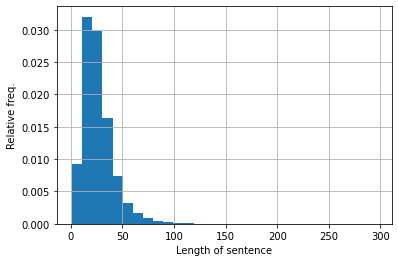

In [30]:
from matplotlib import pyplot as plt
plt.hist(sent_lens,bins=30,density=True,cumulative=False)
plt.grid()
plt.xlabel('Length of sentence');plt.ylabel('Relative freq.')
plt.show()

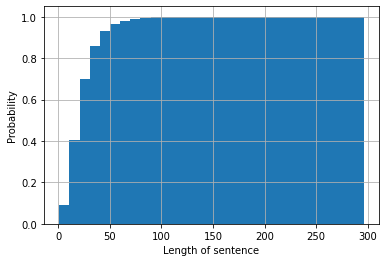

(122, 296)

In [52]:
# Cumulative probability distribution of the sentences
plt.hist(sent_lens,bins=30,density=True,cumulative=True)
plt.grid()
plt.xlabel('Length of sentence');plt.ylabel('Probability')
plt.show()
# How long of a sentence covers 99.9% of the examples?
# How long is the longest sentence in the training set?
int(np.percentile(sent_lens,99.9)), max(sent_lens)

In [38]:
# Text Vectorization layer
len(X_train)
# In the paper (https://arxiv.org/pdf/1710.06071v1.pdf), the authors of the dataset state
# that the vocabulary length is ~68k
max_tokens = 68000

text_vectorizer = layers.experimental.preprocessing.TextVectorization(max_tokens,
                                                                      output_sequence_length=122)
# Adapt to the training sequences
text_vectorizer.adapt(X_train)

In [40]:
import random
random_sentence = random.choice(X_train)
print(f'Text:\n{random_sentence}')
print(f'Length of text:{len(random_sentence)}')
print(f'Vectorized text:\n{text_vectorizer([random_sentence])}')

Text:
It is unclear whether thiazide diuretics ( TZs ) or calcium channel blockers ( CCBs ) are more effective as add-on therapy to angiotensin receptor blockers ( ARBs ) in controlling hypertension .
Length of text:194
Vectorized text:
[[  185    20  1288   180 15354  8477 33458    16   826  7732  3638 23652
     58    69   137    25  2040    66     6  3641   746  3638 10873     5
   1708   659     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [41]:
# Words of our vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(text_vocab)}')
print(f'5 most common words in the vocab: {text_vocab[:5]}')
print(f'5 least common words in the vocab: {text_vocab[-5:]}')

Number of words in vocab: 64841
5 most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
5 least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [42]:
# Config of the vocabulary
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 122,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom text embedding


In [43]:
embedding_layer = layers.Embedding(input_dim=len(text_vocab),
                                   output_dim=512,
                                   mask_zero=True,
                                   name='embedding_layer')

## Creating datasets
_Loading our data as fast as possible..._

In [45]:
# We'll use the tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev,y_dev))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: CONV1D + Token Embeddings

In [50]:
# Create model
inputs = layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(128,kernel_size=5,padding='same',activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = keras.Model(inputs,outputs)
# Compile model and summary
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 122)              0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 122, 512)         33198592  
                                                                 
 conv1d (Conv1D)             (None, 122, 128)          327808    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645   

In [51]:
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              validation_data=dev_dataset)

Epoch 1/5
5627/5627 [==============================] - 142s 23ms/step - loss: 0.5985 - accuracy: 0.7825 - val_loss: 0.5306 - val_accuracy: 0.8092
Epoch 2/5
5627/5627 [==============================] - 130s 23ms/step - loss: 0.4333 - accuracy: 0.8481 - val_loss: 0.5359 - val_accuracy: 0.8099
Epoch 3/5
5627/5627 [==============================] - 130s 23ms/step - loss: 0.3347 - accuracy: 0.8870 - val_loss: 0.5985 - val_accuracy: 0.8053
Epoch 4/5
5627/5627 [==============================] - 129s 23ms/step - loss: 0.2501 - accuracy: 0.9190 - val_loss: 0.7097 - val_accuracy: 0.7918
Epoch 5/5
5627/5627 [==============================] - 129s 23ms/step - loss: 0.1850 - accuracy: 0.9422 - val_loss: 0.8469 - val_accuracy: 0.7815


From the 3rd epoch, the model is overfitting...